# Windy Gridworld with ML-Agents

Environment: [Reinforcement Learning: An Introduction 2nd Edition - Example 6.5: Windy Gridworld](http://incompleteideas.net/book/bookdraft2017nov5.pdf#page=124)

## Environment Settings

I developed the environment using ML-Agents Toolkit. Here is the document of the environment:  
[DevSlem/unity-ml-agents (Github) - Windy Gridworld](https://github.com/DevSlem/unity-ml-agents/wiki/Windy-Gridworld)

Hyperparameters:
* $\epsilon = 0.1$  
* $\alpha = 0.5$  
* $\gamma = 1$  
* 8000 episodes

Random Seed: 0

## Source Codes

### Library

RL agent:
* [Sarsa](../rl/rl_algorithm/sarsa.py)

Environment:
* [Windy Gridworld](../rl/environment/windy_gridworld.py)

### Import basic modules

In [1]:
import sys
import os
sys.path.append(os.pardir)

import rl
import numpy as np

rl.util.seed(0)

### Create UnityEnvironment

In [2]:
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.float_properties_channel import FloatPropertiesChannel

try:
    env.close()
except:
    pass

channel = FloatPropertiesChannel()
env = UnityEnvironment(file_name="../ML-Agents Environments/Windy Gridworld", side_channels=[channel])
env.reset()

#### Behavior name

In [3]:
behavior_name = list(env.behavior_specs)[0]
print(f"Name of the behavior: {behavior_name}")

Name of the behavior: WindyGridworld?team=0


#### Observation/Action space

In [4]:
spec = env.behavior_specs[behavior_name]
action_count = spec.action_spec.discrete_branches[0]

print(f"observation space size: {spec.observation_specs[0].shape[0]}, action count: {action_count}")

observation space size: 2, action count: 4


#### Start position

In [5]:
decision_steps, terminal_steps = env.get_steps(behavior_name)
print(f"start position: {decision_steps.obs[0][0,:]}")

start position: [0. 3.]


### Create Sarsa agent

In [6]:
# hyperparameters
alpha = 0.5
gamma = 1
epsilon = 0.1

sarsa = rl.Sarsa(
    (10, 7),
    action_count,
    [(7, 3)],
    epsilon=epsilon,
    alpha=alpha,
    gamma=gamma
)

### Define train function

In [9]:
from mlagents_envs.environment import ActionTuple
from tqdm import tqdm

def train(env: UnityEnvironment, agent: rl.Agent, episodes_count):
    behavior_name = list(env.behavior_specs)[0]
    rewards_arr = []
    
    for episode in tqdm(range(episodes_count)):
        env.reset()
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        current_states = decision_steps.obs[0].astype(np.int32)
        agent_ids = decision_steps.agent_id
        terminated = False
        total_rewards = 0
        agent.start_episode()
        
        # start an episode
        while not terminated:
            # take action a
            current_actions = [agent.get_action(current_states[id]) for id in agent_ids]
            action_tuple = ActionTuple(discrete=np.array([current_actions]).T)
            env.set_actions(behavior_name, action_tuple)
            env.step()

            decision_steps, terminal_steps = env.get_steps(behavior_name)
            # observe r, s'
            transitions = []
            rewards = []
            next_states = np.empty_like(current_states, dtype=np.int32)
            # at non-terminal time step
            for id in decision_steps:
                next_states[id] = decision_steps[id].obs[0].astype(np.int32)
                reward = decision_steps[id].reward
                transition = rl.Transition(
                    current_states[id],
                    current_actions[id],
                    next_states[id],
                    reward
                )
                transitions.append(transition)
                rewards.append(reward)
            # at terminal time step
            for id in terminal_steps:
                next_states[id] = terminal_steps[id].obs[0].astype(np.int32)
                reward = terminal_steps[id].reward
                transition = rl.Transition(
                    current_states[id],
                    current_actions[id],
                    next_states[id],
                    reward
                )
                transitions.append(transition)
                rewards.append(reward)
                terminated = True
            
            # update q-values
            for transition in transitions:
                agent.update(transition)
            
            current_states = next_states
            total_rewards += np.mean(rewards)
            
        agent.end_episode()
        rewards_arr.append(total_rewards)
        
    return rewards_arr

### Training

In [10]:
episodes_count = 1000
rewards_arr = train(env, sarsa, episodes_count)

100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]


### Define test function

In [11]:
def test(env: UnityEnvironment, agent: rl.Agent, episodes_count, max_timestep):
    for episode in tqdm(range(episodes_count)):
        env.reset()
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        agent_id = 0
        current_state = decision_steps[agent_id].obs[0].astype(np.int32)
        terminated = False
        
        # start an episode
        for t in range(max_timestep):
            # take action a
            current_action = agent.get_action(current_state)
            action_tuple = ActionTuple(discrete=np.array([[current_action]], dtype=np.int32))
            env.set_action_for_agent(behavior_name, agent_id, action_tuple)
            env.step()

            decision_steps, terminal_steps = env.get_steps(behavior_name)
            # observe s'
            if agent_id in decision_steps:
                next_state = decision_steps[agent_id].obs[0].astype(np.int32)
            if agent_id in terminal_steps:
                next_state = terminal_steps[agent_id].obs[0].astype(np.int32)
                terminated = True
            
            if terminated:
                break
            
            current_state = next_state

### Test

In [12]:
channel.set_property("fixedupdate_per_step_when_training", 20) # for rendering
sarsa.epsilon = 0
test(env, sarsa, 10, 200)

100%|██████████| 10/10 [01:03<00:00,  6.39s/it]


### Close the environment

In [13]:
env.close()

### Print training results

average rewards of last 100 rewards


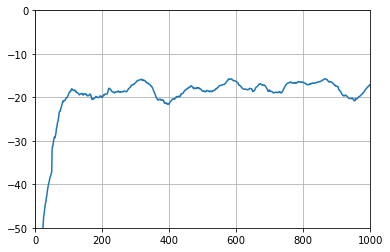

In [14]:
import matplotlib.pyplot as plt

print("average rewards of last 100 rewards")
plt.plot(rl.util.average_last_data(rewards_arr, data_count=50))
plt.grid()
plt.axis([0, episodes_count, -50, 0])
plt.show()